Dataset generated successfully.

First 5 rows of the dataset:
   seismic_activity  vibration_level  joint_water_pressure  displacement_mm  \
0          0.081163         0.651090            106.046123         0.999340   
1          0.190636         0.762810             99.936814         1.493494   
2          0.149079         1.296366             76.423087         1.125334   
3          0.123745         0.576006            141.090001         0.166605   
4          0.039644         1.317510            121.493624         0.371160   

   rainfall_mm rockfall_risk  
0     7.299983        Medium  
1     1.845120           Low  
2     3.466397           Low  
3     6.632806        Medium  
4     4.820893        Medium  

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   seismic_activity      5000 non-null   fl

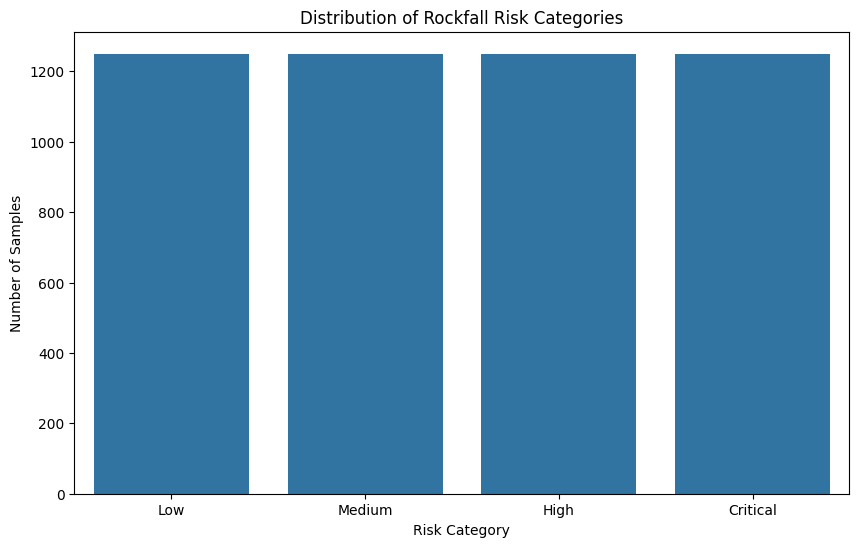

Dataset saved to ../data/rockfall_data.csv


In [4]:
# 1. Import Libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

# 2. Setup Directories
# Ensure the data directory exists
if not os.path.exists('../data'):
    os.makedirs('../data')

# 3. Generate Synthetic Data
num_samples = 5000
np.random.seed(42)

# Base values for stable conditions
data = {
    'seismic_activity': np.random.uniform(0.01, 0.2, num_samples),
    'vibration_level': np.random.uniform(0.1, 1.5, num_samples),
    'joint_water_pressure': np.random.uniform(50, 200, num_samples),
    'displacement_mm': np.random.uniform(0.0, 2.0, num_samples),
    'rainfall_mm': np.random.uniform(0, 10, num_samples)
}

df = pd.DataFrame(data)

# Introduce conditions that lead to higher risk
# High risk scenarios (e.g., 10% of data)
high_risk_indices = np.random.choice(df.index, size=int(num_samples * 0.1), replace=False)
df.loc[high_risk_indices, 'seismic_activity'] *= np.random.uniform(3, 8)
df.loc[high_risk_indices, 'vibration_level'] *= np.random.uniform(2, 5)
df.loc[high_risk_indices, 'joint_water_pressure'] += np.random.uniform(100, 250)
df.loc[high_risk_indices, 'displacement_mm'] += np.random.uniform(3, 10)
df.loc[high_risk_indices, 'rainfall_mm'] += np.random.uniform(20, 50)

# Medium risk scenarios (e.g., 20% of data)
medium_risk_indices = np.random.choice(df.drop(high_risk_indices).index, size=int(num_samples * 0.2), replace=False)
df.loc[medium_risk_indices, 'seismic_activity'] *= np.random.uniform(1.5, 3)
df.loc[medium_risk_indices, 'vibration_level'] *= np.random.uniform(1.5, 3)
df.loc[medium_risk_indices, 'joint_water_pressure'] += np.random.uniform(50, 150)
df.loc[medium_risk_indices, 'displacement_mm'] += np.random.uniform(1, 4)
df.loc[medium_risk_indices, 'rainfall_mm'] += np.random.uniform(10, 30)

# Define risk based on a scoring system
score = (
    df['seismic_activity'] * 2.0 + 
    df['vibration_level'] * 1.5 + 
    df['joint_water_pressure'] * 0.05 + 
    df['displacement_mm'] * 1.0 + 
    df['rainfall_mm'] * 0.2
)

# Define labels for risk categories
labels = ['Low', 'Medium', 'High', 'Critical']

# Use quantile-based binning to ensure a more even class distribution.
# This is the fix for the ValueError.
df['rockfall_risk'] = pd.qcut(score, q=4, labels=labels, duplicates='drop')


# Ensure no missing values in the target
df.dropna(subset=['rockfall_risk'], inplace=True)

print("Dataset generated successfully.")

# 4. Data Exploration
print("\nFirst 5 rows of the dataset:")
print(df.head())

print("\nDataset Information:")
df.info()

print("\nDescriptive Statistics:")
print(df.describe())

# 5. Check Class Distribution
print("\nPlotting class distribution...")
plt.figure(figsize=(10, 6))
sns.countplot(x='rockfall_risk', data=df, order=['Low', 'Medium', 'High', 'Critical'])
plt.title('Distribution of Rockfall Risk Categories')
plt.xlabel('Risk Category')
plt.ylabel('Number of Samples')
plt.show()

# 6. Save the Dataset
output_path = '../data/rockfall_data.csv'
df.to_csv(output_path, index=False)

print(f"Dataset saved to {output_path}")

